In [1]:
"""Runs nested cross validation."""
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "../code"))
from os import environ
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import logging
from sklearn.preprocessing import LabelEncoder

from training import training_loop
from utils import balanced_data_shuffle, get_df_raw_data
from models import MRICustomAttention

## Data path ##
DATA_PATH = (Path.cwd().parent / "DATA").resolve()
print(f"Data path: {DATA_PATH}")
DATA_PATH = str(DATA_PATH)
logging.basicConfig(level=logging.INFO)

# set deterministic behavior
seed = 53498298
torch.manual_seed(seed)
np.random.seed(seed)

torch.use_deterministic_algorithms(True)
environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

Data path: C:\Users\Cyril\Desktop\Code\MIPLab-TeamCEE-DeepLearningforBiomed\DATA


## Config

In [2]:
config = {
    # data
    "stratify": True,
    "validation_split": 0,
    # general
    "epochs": 50,
    "batch_size": 32,
    "lr": 1e-4,
    "use_scheduler": False,
    "do_early_stopping": False,
    "patience": 10,
    "best_loss": 10,
    # model
    "d_model_input": 400,
    "d_model_intermediate": 1000,
    "d_model_task_output": 8,
    "d_model_fingerprint_output": None,  # needs to be determined from data
    "dropout": 0,
    "attention_dropout": 0.1,
    "num_heads": 1,
    # optimizer
    "lambda_si": 0.5,
    "lambda_td": 0.5,
    "weight_decay": 1,
}

In [3]:
IDs = [
    100307,
    117122,
    131722,
    153025,
    211720,
    100408,
    118528,
    133019,
    154734,
    212318,
    101107,
    118730,
    133928,
    156637,
    214423,
    101309,
    118932,
    135225,
    159340,
    221319,
    101915,
    120111,
    135932,
    160123,
    239944,
    103111,
    122317,
    136833,
    161731,
    245333,
    103414,
    122620,
    138534,
    162733,
    280739,
    103818,
    123117,
    139637,
    163129,
    298051,
    105014,
    123925,
    140925,
    176542,
    366446,
    105115,
    124422,
    144832,
    178950,
    397760,
    106016,
    125525,
    146432,
    188347,
    414229,
    108828,
    126325,
    147737,
    189450,
    499566,
    110411,
    127630,
    148335,
    190031,
    654754,
    111312,
    127933,
    148840,
    192540,
    672756,
    111716,
    128127,
    149337,
    196750,
    751348,
    113619,
    128632,
    149539,
    198451,
    756055,
    113922,
    129028,
    149741,
    199655,
    792564,
    114419,
    130013,
    151223,
    201111,
    856766,
    115320,
    130316,
    151526,
    208226,
    857263,
]


In [4]:
def _show_df_distribution(df):
    print("Number of samples:", len(df))
    print("Unique subjects:", df["subject_id"].nunique())
    print("Unique tasks:", df["task"].nunique())
    print("*" * 50)

## Joining train and test dataframes from all subjects

In [5]:
# data_dict_train, data_dict_test = get_dict_raw_data(DATA_PATH, IDs[0:3])
data_df_train, data_df_test = get_df_raw_data(DATA_PATH, IDs[:])

train_dataframe, valid_dataframe = balanced_data_shuffle(
    data_df_train,
    val_frac=config["validation_split"],
    stratify=config["stratify"],
)
NUM_SUBJECTS = len(data_df_train["subject_id"].unique())
print(f"Number of subjects: {NUM_SUBJECTS}")
NUM_TASKS = data_df_train["task"].nunique()
print(f"Number of tasks: {NUM_TASKS}")

#
###-------------------------------------------------------------------------------------------------------------------
#         label encoding
###-------------------------------------------------------------------------------------------------------------------
enc_labels = LabelEncoder()
enc_tasks = LabelEncoder()

enc_labels.fit(data_df_train["subject_id"].tolist())
enc_tasks.fit(data_df_train["task"].tolist())

enc_train_label_encodings = enc_labels.transform(
    train_dataframe["subject_id"].tolist()
)
enc_train_task_encodings = enc_tasks.transform(
    train_dataframe["task"].tolist()
)

enc_test_label_encodings = enc_labels.transform(
    data_df_test["subject_id"].tolist()
)
enc_test_task_encodings = enc_tasks.transform(
    data_df_test["task"].tolist()
)

train_dataframe["enc_label_id"] = enc_train_label_encodings
train_dataframe["enc_task"] = enc_train_task_encodings
data_df_test["enc_label_id"] = enc_test_label_encodings
data_df_test["enc_task"] = enc_test_task_encodings

print("Subjects present in train set but not in test set:")
overlap_set = set(train_dataframe["subject_id"].unique()) - set(
    data_df_test["subject_id"].unique()
)
print(overlap_set)
if len(overlap_set) != 0:
    print("WARNING: subjects present in train set but not in test set")

print("Train set:")
_show_df_distribution(train_dataframe)
print("Test set:")
_show_df_distribution(data_df_test)

Number of subjects: 95
Number of tasks: 8
Subjects present in train set but not in test set:
set()
Train set:
Number of samples: 760
Unique subjects: 95
Unique tasks: 8
**************************************************
Test set:
Number of samples: 758
Unique subjects: 95
Unique tasks: 8
**************************************************


## Dataloaders

In [6]:
train_dataset = TensorDataset(
    torch.tensor(
        np.array(train_dataframe["mat"].tolist()).astype(np.float32)
    ),
    torch.tensor(train_dataframe["enc_label_id"].to_numpy()),
    torch.tensor(train_dataframe["enc_task"].to_numpy()),
)
train_loader = DataLoader(
    train_dataset, batch_size=config["batch_size"], shuffle=True
)

test_dataset = TensorDataset(
    torch.tensor(
        np.array(data_df_test["mat"].tolist()).astype(np.float32)
    ),
    torch.tensor(data_df_test["enc_label_id"].to_numpy()),
    torch.tensor(data_df_test["enc_task"].to_numpy()),
)
test_loader = DataLoader(
    test_dataset, batch_size=config["batch_size"], shuffle=False
)

valid_loader = None
if valid_dataframe is not None:
    enc_valid_label_encodings = enc_labels.transform(
        valid_dataframe["subject_id"].tolist()
    )
    enc_valid_task_encodings = enc_tasks.transform(
        valid_dataframe["task"].tolist()
    )
    valid_dataframe["enc_label_id"] = enc_valid_label_encodings
    valid_dataframe["enc_task"] = enc_valid_task_encodings
    print("Subjects present in validation set but not in train set:")
    overlap_set = set(valid_dataframe["subject_id"].unique()) - set(
        train_dataframe["subject_id"].unique()
    )
    print(overlap_set)
    if len(overlap_set) != 0:
        print(
            "WARNING: subjects present in validation set but not in train set"
        )
    valid_dataset = TensorDataset(
        torch.tensor(
            np.array(valid_dataframe["mat"].tolist()).astype(np.float32)
        ),
        torch.tensor(valid_dataframe["enc_label_id"].to_numpy()),
        torch.tensor(valid_dataframe["enc_task"].to_numpy()),
    )
    valid_loader = DataLoader(
        valid_dataset, batch_size=config["batch_size"], shuffle=False
    )
    print("Validation set:")
    _show_df_distribution(valid_dataframe)


## Training

Using device: cuda:0
Using cuda:0


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: c-achard. Use `wandb login --relogin` to force relogin


Epoch: 1/50 - loss_total: 2.5685 - acc: SI 16.93% / TD 72.48%
 - (1.91s/epoch)
Epoch: 2/50 - loss_total: 1.3706 - acc: SI 87.85% / TD 96.44%
 - (1.21s/epoch)
Epoch: 3/50 - loss_total: 0.6055 - acc: SI 99.87% / TD 99.35%
 - (1.14s/epoch)
Epoch: 4/50 - loss_total: 0.2430 - acc: SI 99.87% / TD 100.00%
 - (1.14s/epoch)
Epoch: 5/50 - loss_total: 0.1319 - acc: SI 100.00% / TD 100.00%
 - (1.15s/epoch)
Epoch: 6/50 - loss_total: 0.0856 - acc: SI 100.00% / TD 100.00%
 - (1.15s/epoch)
Epoch: 7/50 - loss_total: 0.0627 - acc: SI 100.00% / TD 100.00%
 - (1.20s/epoch)
Epoch: 8/50 - loss_total: 0.0514 - acc: SI 100.00% / TD 100.00%
 - (1.15s/epoch)
Epoch: 9/50 - loss_total: 0.0441 - acc: SI 100.00% / TD 100.00%
 - (1.15s/epoch)
Epoch: 10/50 - loss_total: 0.0386 - acc: SI 100.00% / TD 100.00%
 - (1.16s/epoch)
Epoch: 11/50 - loss_total: 0.0351 - acc: SI 100.00% / TD 100.00%
 - (1.16s/epoch)
Epoch: 12/50 - loss_total: 0.0316 - acc: SI 100.00% / TD 100.00%
 - (1.16s/epoch)
Epoch: 13/50 - loss_total: 0.029

c:\Users\Cyril\anaconda3\envs\DLbiomed\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\Users\Cyril\anaconda3\envs\DLbiomed\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Running DeepLIFT for task REST1
deeplift mode
x in torch.Size([48, 400, 400])
x out torch.Size([48, 8])
TD attributions shape :  torch.Size([24, 400, 400])
Running DeepLIFT for task EMOTION
deeplift mode
x in torch.Size([48, 400, 400])
x out torch.Size([48, 8])
TD attributions shape :  torch.Size([24, 400, 400])
Running DeepLIFT for task GAMBLING
deeplift mode
x in torch.Size([48, 400, 400])
x out torch.Size([48, 8])
TD attributions shape :  torch.Size([24, 400, 400])
Running DeepLIFT for task LANGUAGE
deeplift mode
x in torch.Size([48, 400, 400])
x out torch.Size([48, 8])
TD attributions shape :  torch.Size([24, 400, 400])
Running DeepLIFT for task MOTOR
deeplift mode
x in torch.Size([48, 400, 400])
x out torch.Size([48, 8])
TD attributions shape :  torch.Size([24, 400, 400])
Running DeepLIFT for task RELATIONAL
deeplift mode
x in torch.Size([48, 400, 400])
x out torch.Size([48, 8])
TD attributions shape :  torch.Size([24, 400, 400])
Running DeepLIFT for task SOCIAL
deeplift mode
x in

Epoch/Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Test/acc_si,▁
Test/acc_td,▁
Test/f1_si,▁
Test/f1_td,▁
Test/loss_si,▁
Test/loss_td,▁
Test/total_loss,▁
Train/Epoch-acc_si,▁▇██████████████████████████████████████
Train/Epoch-acc_td,▁▇██████████████████████████████████████
Train/Epoch-loss_si,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Finished Training.


{'epoch': 50,
 'loss_total': [2.568502595027288,
  1.370582511027654,
  0.6055328485866388,
  0.24303871703644594,
  0.1318545344596108,
  0.08559935043255489,
  0.06271489166344206,
  0.05139913301294049,
  0.04410981868083278,
  0.038578972375641264,
  0.03509974363259971,
  0.031648780995359026,
  0.029556473329042394,
  0.027291994852324326,
  0.025158598320558667,
  0.02348940431450804,
  0.023311371526991326,
  0.02086627421279748,
  0.020107967623819906,
  0.019239897684504587,
  0.01803523146857818,
  0.01763909248014291,
  0.016869493915388983,
  0.01645624137017876,
  0.015517789249618849,
  0.015115896860758463,
  0.014370358587863544,
  0.01413418228427569,
  0.013614600524306297,
  0.013427212097061178,
  0.01307881681714207,
  0.012902864099790653,
  0.012536605237983167,
  0.012132426879058281,
  0.01196117679743717,
  0.011554966331459582,
  0.011404168830874065,
  0.010821019144107899,
  0.0107095050237452,
  0.010664176273470124,
  0.010432883126971623,
  0.0101161369

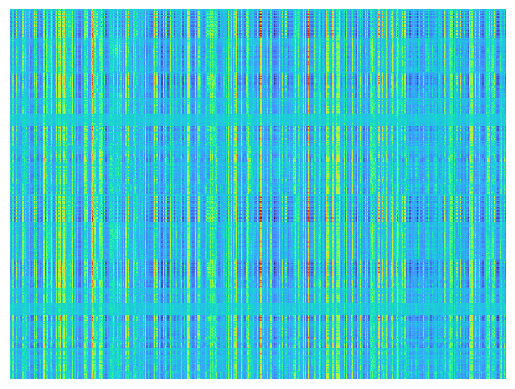

In [7]:
###-------------------------------------------------------------------------------------------------------------------
#         Model
###-------------------------------------------------------------------------------------------------------------------

# list all available torch devices
device_list = ["cpu"] + [
    f"cuda:{i}" for i in range(torch.cuda.device_count())
]
device = device_list[-1] if torch.cuda.is_available() else device_list[0]
print(f"Using device: {device}")
model = MRICustomAttention(
            output_size_subjects=NUM_SUBJECTS,
            output_size_tasks=NUM_TASKS,
            input_size=config["d_model_input"],
            attention_dropout=config["attention_dropout"],
            intermediate_size=config["d_model_intermediate"],
            intermediate_dropout=config["dropout"],
        ).to(device)
wandb_run_name = (
    "EGNNA_best_reproduction_FINAL"
)


###-------------------------------------------------------------------------------------------------------------------
#         training
###-------------------------------------------------------------------------------------------------------------------

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config["lr"],
    weight_decay=config["weight_decay"],
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=20, gamma=0.1
)

training_loop(
    config["epochs"],
    model,
    train_loader,
    valid_loader,
    criterion,
    optimizer,
    device,
    config,
    scheduler=scheduler if config["use_scheduler"] else None,
    save_model=True,
    save_attention_weights=True,
    test_loader=test_loader,
    run_name=wandb_run_name,
    job_name="EGNNA",
    use_deeplift=True,
    use_early_stopping=config["do_early_stopping"],
)
